## initialization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [67]:
pd.set_option("display.max_columns", None)
data = pd.read_csv("Airline_Delay_Cause.csv")
data.drop(['carrier_name','airport_name','arr_cancelled','arr_diverted'], axis=1,inplace=True)
data.info()

display(data.describe())
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   airport              179338 non-null  object 
 4   arr_flights          178997 non-null  float64
 5   arr_del15            178747 non-null  float64
 6   carrier_ct           178997 non-null  float64
 7   weather_ct           178997 non-null  float64
 8   nas_ct               178997 non-null  float64
 9   security_ct          178997 non-null  float64
 10  late_aircraft_ct     178997 non-null  float64
 11  arr_delay            178997 non-null  float64
 12  carrier_delay        178997 non-null  float64
 13  weather_delay        178997 non-null  float64
 14  nas_delay            178997 non-null  float64
 15  security_delay   

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,179338.000000,179338.000000,178997.000000,178747.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000
mean,2019.480082,6.485725,327.816969,58.709086,18.572643,2.035742,17.094929,0.145307,20.778477,3863.310676,1325.546199,209.113426,819.949284,6.839941,1501.854875
std,2.410204,3.463516,931.001446,164.378035,47.389651,6.894812,56.279604,0.702149,64.912766,11902.153241,4067.786987,791.817638,3178.603458,40.440497,4878.178427
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,6.000000,1.960000,0.000000,1.000000,0.000000,1.000000,288.000000,91.000000,0.000000,28.000000,0.000000,54.000000
50%,2020.000000,6.000000,89.000000,15.000000,5.400000,0.220000,3.300000,0.000000,4.290000,900.000000,321.000000,12.000000,124.000000,0.000000,286.000000
75%,2022.000000,9.000000,218.000000,40.000000,14.700000,1.620000,9.860000,0.000000,13.010000,2547.000000,986.000000,131.000000,401.000000,0.000000,964.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,438783.000000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,ABE,72.0,5.0,2.46,1.00,0.73,0.00,0.81,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,AEX,62.0,7.0,4.25,0.00,1.00,0.00,1.75,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,AGS,95.0,10.0,5.94,0.00,1.06,0.00,3.00,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,ALB,23.0,2.0,0.56,0.00,0.00,0.00,1.44,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,ATL,2111.0,256.0,76.88,8.75,52.43,0.00,117.94,21424.0,8906.0,732.0,1487.0,0.0,10299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179333,2015,1,WN,ONT,892.0,184.0,59.21,2.61,22.41,0.98,98.79,8431.0,2661.0,123.0,1029.0,92.0,4526.0
179334,2015,1,WN,ORF,151.0,45.0,18.00,2.01,7.19,0.00,17.80,2391.0,840.0,295.0,301.0,0.0,955.0
179335,2015,1,WN,PBI,251.0,68.0,25.17,0.08,14.92,0.00,27.83,3405.0,1003.0,9.0,534.0,0.0,1859.0
179336,2015,1,WN,PDX,793.0,173.0,64.00,1.27,21.12,0.00,86.60,7479.0,2370.0,143.0,689.0,0.0,4277.0


# Transformation of data

In [ ]:
# normalized data per arrival flight
dataNormalized = data.copy()
delay_cols = data.loc[:,'arr_del15':'late_aircraft_delay']
delay_cols = delay_cols.div(data['arr_flights'], axis=0)
dataNormalized.loc[:,'arr_del15':'late_aircraft_delay'] = delay_cols

display(dataNormalized.describe())
dataNormalized.head()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,179338.000000,179338.000000,178997.000000,178747.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000,178997.000000
mean,2019.480082,6.485725,327.816969,0.180415,0.066317,0.007903,0.047818,0.000437,0.057690,11.837256,4.537144,0.868504,2.083489,0.020465,4.327623
std,2.410204,3.463516,931.001446,0.114585,0.061925,0.019375,0.053283,0.003303,0.056879,15.327833,11.403001,5.524817,3.240477,0.231514,5.820135
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,0.105263,0.032083,0.000000,0.013539,0.000000,0.017857,5.137931,1.516129,0.000000,0.460000,0.000000,0.836957
50%,2020.000000,6.000000,89.000000,0.166667,0.055672,0.001250,0.036282,0.000000,0.047419,9.516129,3.141700,0.068826,1.325397,0.000000,2.981618
75%,2022.000000,9.000000,218.000000,0.238018,0.086944,0.009873,0.065893,0.000000,0.082876,15.518519,5.576923,0.724138,2.659774,0.000000,5.924731
max,2023.000000,12.000000,21977.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,3174.000000,3166.000000,1244.000000,403.000000,43.000000,418.000000


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,ABE,72.0,0.069444,0.034167,0.013889,0.010139,0.0,0.011250,9.333333,0.847222,7.972222,0.277778,0.0,0.236111
1,2023,12,9E,AEX,62.0,0.112903,0.068548,0.000000,0.016129,0.0,0.028226,5.612903,4.064516,0.000000,0.532258,0.0,1.016129
2,2023,12,9E,AGS,95.0,0.105263,0.062526,0.000000,0.011158,0.0,0.031579,9.042105,5.642105,0.000000,0.494737,0.0,2.905263
3,2023,12,9E,ALB,23.0,0.086957,0.024348,0.000000,0.000000,0.0,0.062609,3.260870,0.391304,0.000000,0.000000,0.0,2.869565
4,2023,12,9E,ATL,2111.0,0.121270,0.036419,0.004145,0.024837,0.0,0.055869,10.148745,4.218854,0.346755,0.704405,0.0,4.878730


<Axes: xlabel='cause', ylabel='delay'>

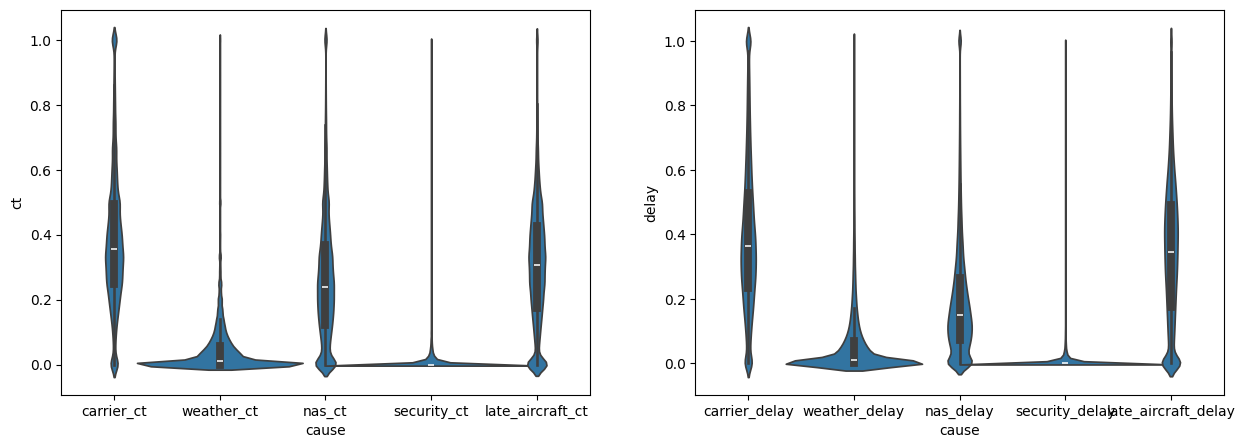

In [26]:
ct_cols = data.loc[:,'carrier_ct':'late_aircraft_ct']
ct_cols = ct_cols.div(data['arr_del15'], axis=0)

delay_cols = data.loc[:,'carrier_delay':'late_aircraft_delay']
delay_cols = delay_cols.div(data['arr_delay'], axis=0)

ct_melted = ct_cols.melt(var_name='cause',value_name='ct')
delay_melted = delay_cols.melt(var_name='cause',value_name='delay')

_,axs = plt.subplots(1,2,figsize=(15,5))
sns.violinplot(data=ct_melted,x='cause',y='ct',width=2,ax=axs[0])
sns.violinplot(data=delay_melted,x='cause',y='delay',width=2,ax=axs[1])

percent of data points with arrival flights less than or equal to 10 :6.6278035435559755


<Axes: xlabel='arr_delay', ylabel='Density'>

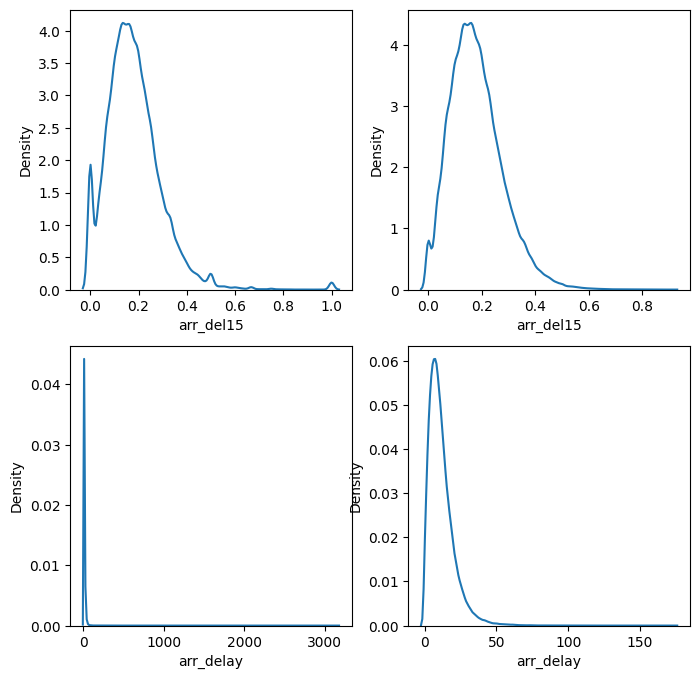

In [32]:
# removing data points with less number of arrival flights 

cutoff = 10
print (f"percent of data points with arrival flights less than or equal to {cutoff} :{sum(dataNormalized['arr_flights']<=cutoff)/len(dataNormalized)*100}")
data_low_Arr_droped = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized['arr_flights'] > cutoff) if x],:]

_,axs = plt.subplots(2,2,figsize=(8,8))
sns.kdeplot(data=dataNormalized, x = 'arr_del15',ax=axs[0,0])
sns.kdeplot(data=dataNormalized, x = 'arr_delay',ax=axs[1,0])

sns.kdeplot(data=data_low_Arr_droped, x = 'arr_del15',ax=axs[0,1])
sns.kdeplot(data=data_low_Arr_droped, x = 'arr_delay',ax=axs[1,1])


In [71]:
# imputation of data 
carriers = dataNormalized.carrier.unique()
median_vals = pd.DataFrame()

for car in carriers:
    median_vals[car] = data_low_Arr_droped[data_low_Arr_droped.carrier == car].loc[:,'arr_del15':'late_aircraft_delay'].describe().loc['50%']

median_vals

,9E,AA,OH,OO,WN,AS,DL,PT,QX,UA,YV,B6,F9,G4,G7,HA,MQ,YX,ZW,C5,NK,EM,EV,AX,CP,KS,9K,VX,US
arr_del15,0.124101,0.196481,0.171679,0.153846,0.191444,0.142857,0.123711,0.142857,0.121951,0.184100,0.185185,0.234638,0.222222,0.190476,0.181818,0.166667,0.160714,0.141667,0.175506,0.214286,0.196014,0.127858,0.180993,0.250000,0.166667,0.305000,0.083871,0.193548,0.197040
carrier_ct,0.041667,0.072836,0.051687,0.062745,0.066613,0.040222,0.053445,0.033121,0.043077,0.058547,0.076923,0.095486,0.068333,0.058333,0.054237,0.129032,0.040759,0.034389,0.047921,0.080000,0.048267,0.030926,0.063836,0.074371,0.050292,0.081187,0.042645,0.044864,0.073661
weather_ct,0.000000,0.004851,0.004717,0.005407,0.001773,0.000000,0.003718,0.003708,0.000000,0.003968,0.002692,0.001652,0.000000,0.000000,0.000000,0.000000,0.008356,0.001317,0.000000,0.000563,0.002230,0.000000,0.000000,0.001033,0.000000,0.018639,0.000000,0.007407,0.000931
nas_ct,0.031746,0.043084,0.043766,0.016854,0.024950,0.049380,0.027362,0.040000,0.028571,0.041756,0.033613,0.053096,0.062796,0.045714,0.042357,0.000000,0.048987,0.047651,0.042075,0.053333,0.084557,0.012379,0.047079,0.053400,0.030319,0.058769,0.016452,0.048654,0.068900
security_ct,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
late_aircraft_ct,0.031073,0.061115,0.057858,0.041294,0.085139,0.033060,0.026912,0.048545,0.034091,0.062258,0.048387,0.063501,0.068540,0.059589,0.060035,0.022776,0.048429,0.041443,0.062981,0.055042,0.041758,0.074442,0.056619,0.098676,0.065699,0.065218,0.021613,0.068548,0.041396
arr_delay,7.354187,11.429412,9.727502,10.014342,8.990823,6.140400,6.739130,8.254717,5.149504,11.179775,12.877193,14.936492,13.658537,11.705882,12.571429,6.470714,8.116667,7.945181,11.759745,15.387993,12.289693,5.961038,11.133974,18.555556,10.320389,16.523990,2.541935,10.120370,9.147780
carrier_delay,2.516568,4.226627,2.810970,4.148476,3.066804,2.042934,3.033126,1.759958,1.941562,3.295890,4.877778,6.119492,3.917563,3.773050,3.484848,4.892447,1.890625,2.022131,2.944709,5.185616,3.001880,1.582091,4.384118,4.879310,3.374390,5.123325,1.316129,2.274953,3.785952
weather_delay,0.000000,0.334516,0.269231,0.299907,0.113106,0.000000,0.209546,0.201196,0.000000,0.260073,0.161765,0.125743,0.000000,0.000000,0.000000,0.000000,0.467742,0.072624,0.000000,0.050826,0.119400,0.000000,0.000000,0.087719,0.000000,1.006643,0.000000,0.253731,0.053814
nas_delay,1.181595,1.575875,1.500000,0.644253,0.906444,1.464880,0.948980,1.407407,0.771844,1.600000,1.235294,2.263266,2.588235,1.646707,1.666667,0.000000,1.806452,1.795558,1.620185,2.113961,4.478593,0.416959,1.825699,2.294118,1.019019,2.267410,0.373333,1.857895,2.315465


In [72]:
for i in range(len(dataNormalized)):
    if dataNormalized.arr_flights.iloc[i] <= 10 or dataNormalized.iloc[i].isna().any():
        dataNormalized.iloc[i,5:] = median_vals.loc[:,dataNormalized.iloc[i,2]]

dataNormalized 

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,ABE,72.0,0.069444,0.034167,0.013889,0.010139,0.000000,0.011250,9.333333,0.847222,7.972222,0.277778,0.000000,0.236111
1,2023,12,9E,AEX,62.0,0.112903,0.068548,0.000000,0.016129,0.000000,0.028226,5.612903,4.064516,0.000000,0.532258,0.000000,1.016129
2,2023,12,9E,AGS,95.0,0.105263,0.062526,0.000000,0.011158,0.000000,0.031579,9.042105,5.642105,0.000000,0.494737,0.000000,2.905263
3,2023,12,9E,ALB,23.0,0.086957,0.024348,0.000000,0.000000,0.000000,0.062609,3.260870,0.391304,0.000000,0.000000,0.000000,2.869565
4,2023,12,9E,ATL,2111.0,0.121270,0.036419,0.004145,0.024837,0.000000,0.055869,10.148745,4.218854,0.346755,0.704405,0.000000,4.878730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179333,2015,1,WN,ONT,892.0,0.206278,0.066379,0.002926,0.025123,0.001099,0.110751,9.451794,2.983184,0.137892,1.153587,0.103139,5.073991
179334,2015,1,WN,ORF,151.0,0.298013,0.119205,0.013311,0.047616,0.000000,0.117881,15.834437,5.562914,1.953642,1.993377,0.000000,6.324503
179335,2015,1,WN,PBI,251.0,0.270916,0.100279,0.000319,0.059442,0.000000,0.110876,13.565737,3.996016,0.035857,2.127490,0.000000,7.406375
179336,2015,1,WN,PDX,793.0,0.218159,0.080706,0.001602,0.026633,0.000000,0.109206,9.431274,2.988651,0.180328,0.868852,0.000000,5.393443


# EDA

In [105]:
# linear correlation 
dataNormalized.drop(['carrier','airport'],axis=1).corr()

# strong correlation between arr_del15 and cause of delay is obv except security delay which is low showing that expectedly security issues are rare and independent of number of arrival flights
# strong corr of X_delay with X_ct other than arr_del15 and ar_delay 

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,0.001306,-0.045296,0.017513,0.104532,0.050726,-0.054312,0.041788,-0.033215,0.038023,-0.008493,0.053325,0.087942,0.049574,-0.043611,0.030559,0.012839
month,0.001306,1.000000,0.004099,-0.033801,-0.011007,-0.037209,-0.040158,0.004727,-0.010498,-0.158731,-0.011154,-0.028082,-0.008282,-0.022385,-0.040527,0.002908,-0.011831
arr_flights,-0.045296,0.004099,1.000000,-0.004594,-0.070605,-0.044186,0.036175,0.000313,0.038668,-0.020793,-0.018766,0.002400,-0.029754,-0.029922,0.058313,0.000938,0.017931
arr_del15,0.017513,-0.033801,-0.004594,1.000000,0.672794,0.265732,0.597554,0.098212,0.733712,-0.042434,0.027561,0.776706,0.502378,0.153234,0.520310,0.074885,0.638319
carrier_ct,0.104532,-0.011007,-0.070605,0.672794,1.000000,0.110807,0.069942,0.073514,0.283629,-0.055920,0.007607,0.526445,0.686633,0.066780,0.080590,0.060967,0.261803
weather_ct,0.050726,-0.037209,-0.044186,0.265732,0.110807,1.000000,0.076708,0.026100,0.076342,0.010879,0.056150,0.305444,0.109995,0.611818,0.099026,0.030279,0.095803
nas_ct,-0.054312,-0.040158,0.036175,0.597554,0.069942,0.076708,1.000000,0.043118,0.196674,-0.020974,0.040080,0.373940,0.072884,0.030710,0.806805,0.025128,0.189400
security_ct,0.041788,0.004727,0.000313,0.098212,0.073514,0.026100,0.043118,1.000000,0.024039,-0.011342,0.011099,0.051639,0.038858,0.009991,0.041382,0.696210,0.006678
late_aircraft_ct,-0.033215,-0.010498,0.038668,0.733712,0.283629,0.076342,0.196674,0.024039,1.000000,-0.014312,-0.004878,0.622348,0.244598,0.044045,0.201399,0.021417,0.831144
arr_cancelled,0.038023,-0.158731,-0.020793,-0.042434,-0.055920,0.010879,-0.020974,-0.011342,-0.014312,1.000000,0.040586,0.006628,-0.012429,0.013904,0.015416,-0.005823,0.009244


<Axes: xlabel='carrier', ylabel='arr_delay'>

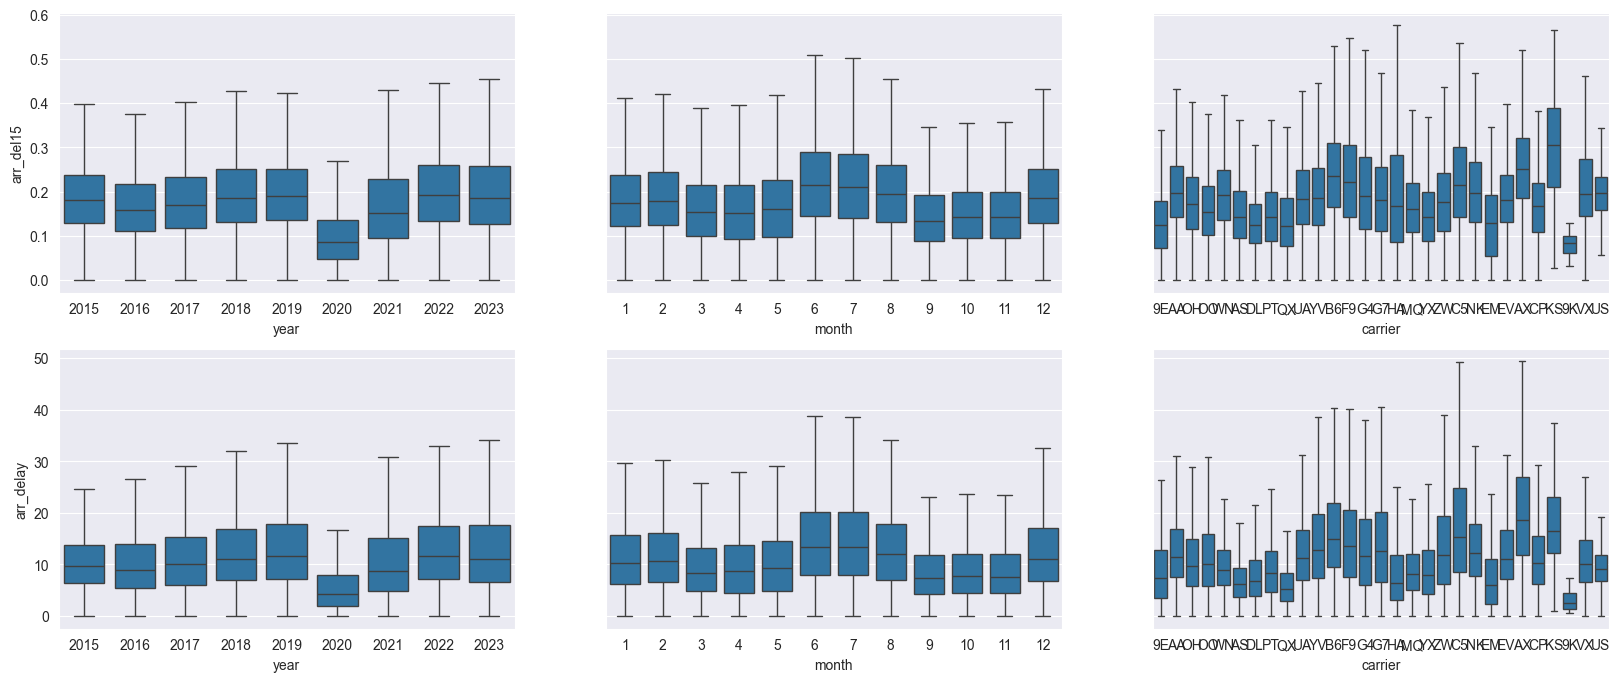

In [171]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(2,3,figsize=(20,8), sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='arr_del15',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='arr_del15',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='arr_del15',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='arr_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='arr_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='arr_delay',ax=axs[1,2],showfliers=False)


np.float64(0.057116034271725825)

<Axes: xlabel='carrier', ylabel='carrier_delay'>

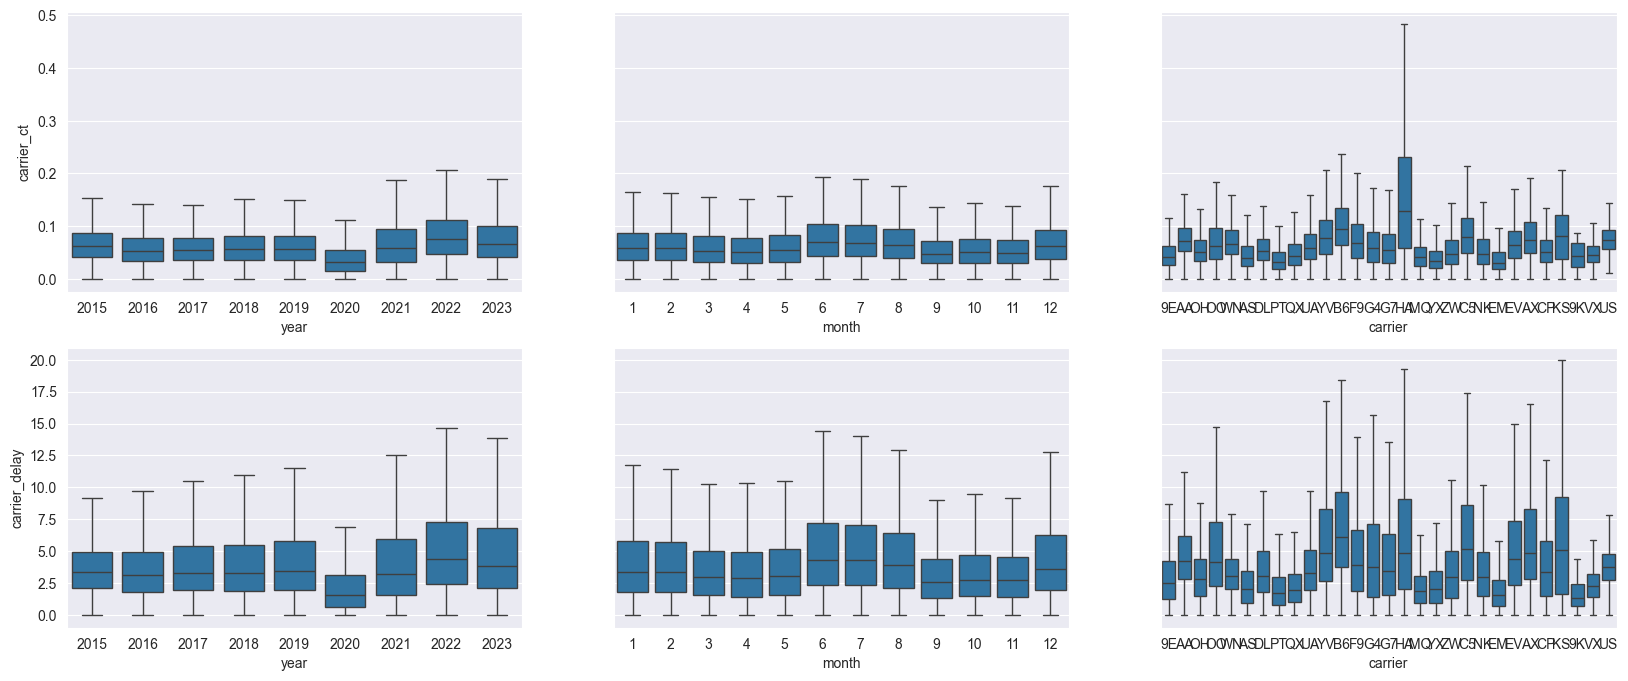

In [172]:
fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='carrier_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='carrier_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='carrier_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='carrier_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='carrier_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='carrier_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='weather_delay'>

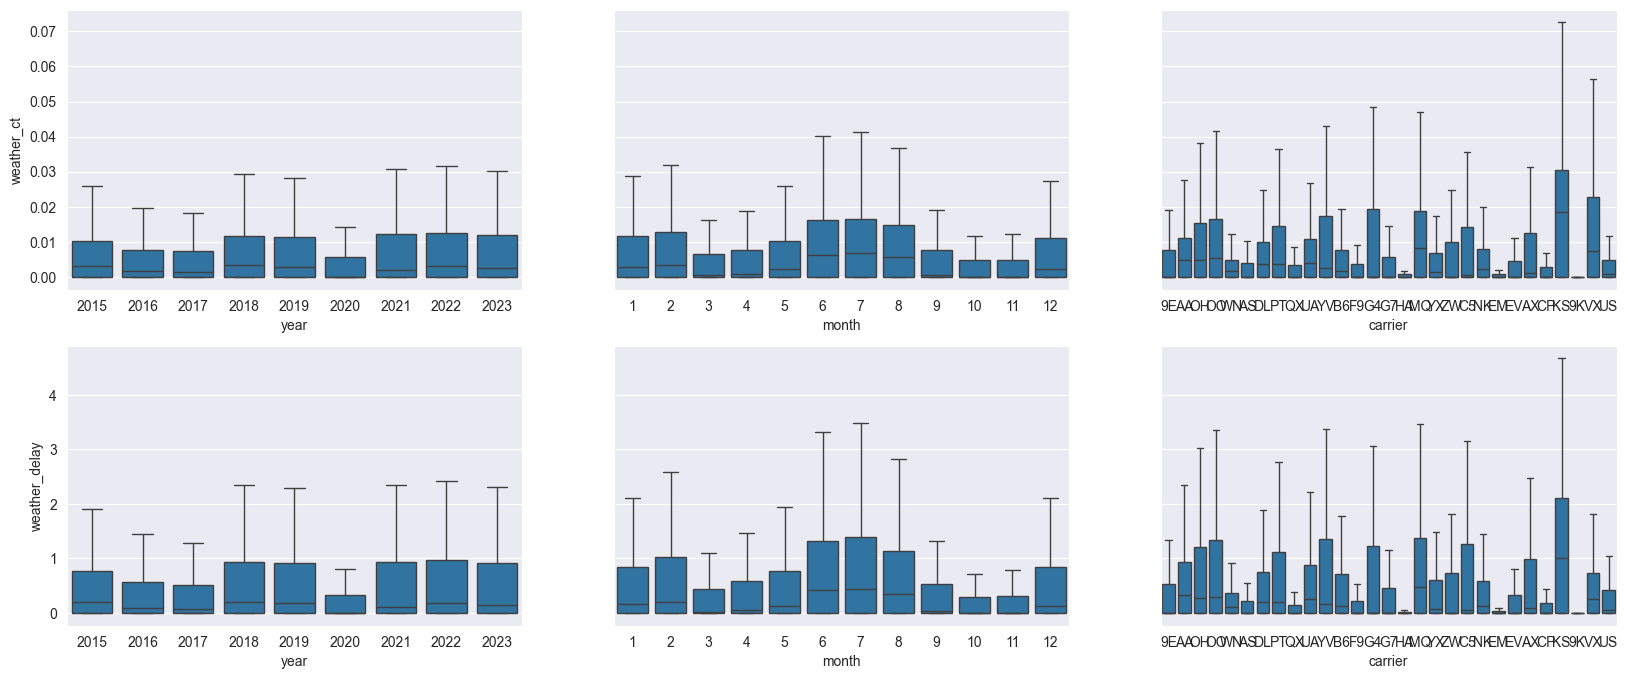

In [173]:
fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='weather_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='weather_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='weather_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='weather_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='weather_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='weather_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='nas_delay'>

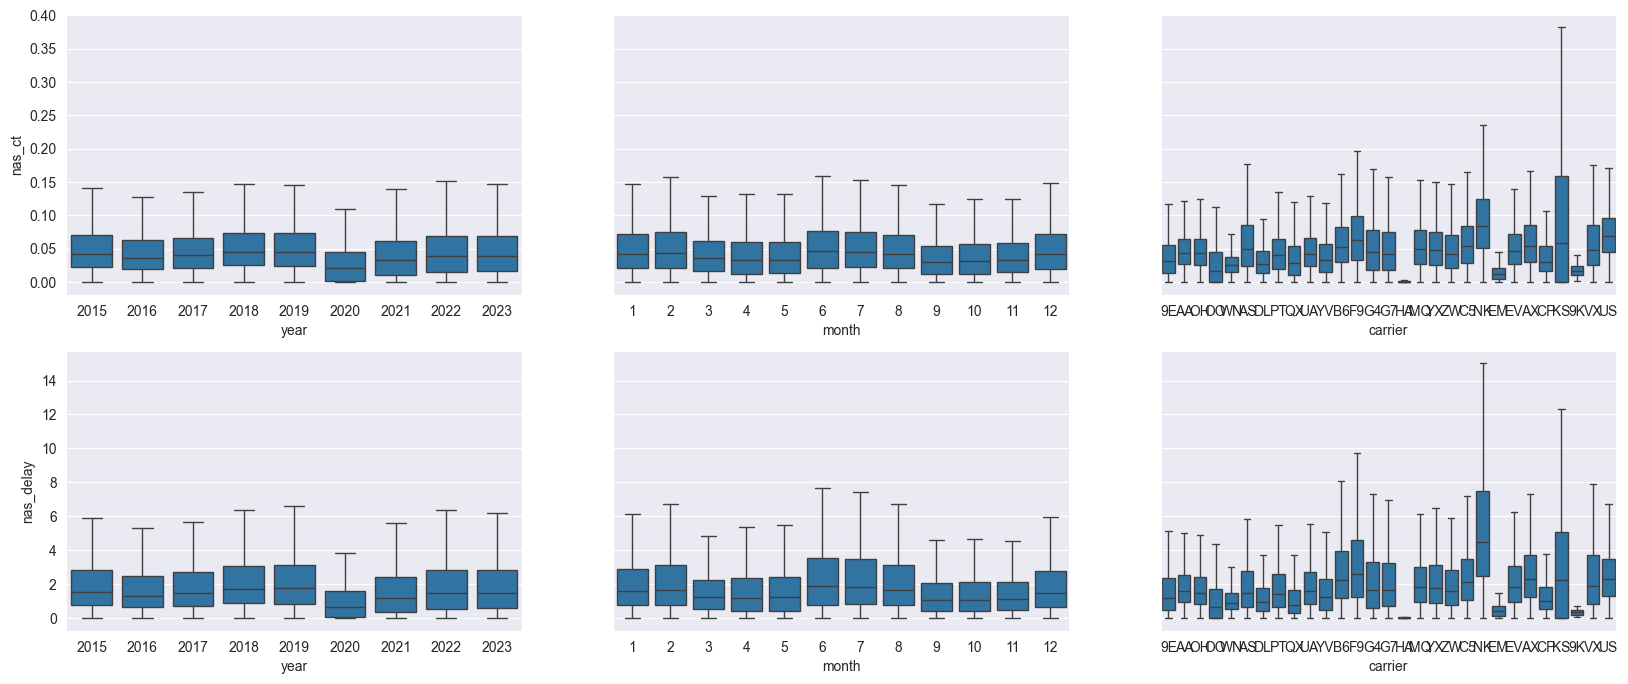

In [174]:
fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='nas_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='nas_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='nas_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='nas_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='nas_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='nas_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='security_delay'>

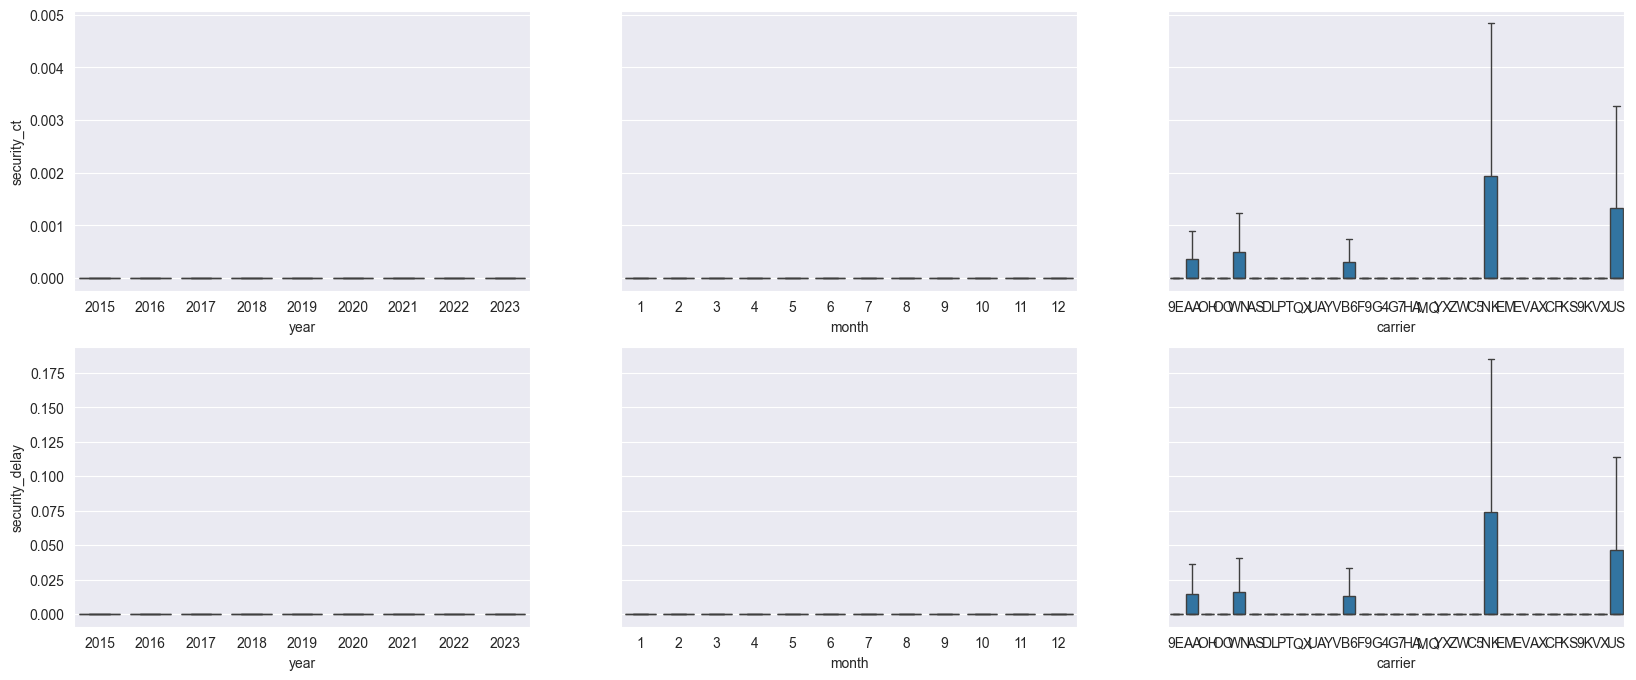

In [175]:
fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='security_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='security_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='security_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='security_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='security_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='security_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='carrier', ylabel='late_aircraft_delay'>

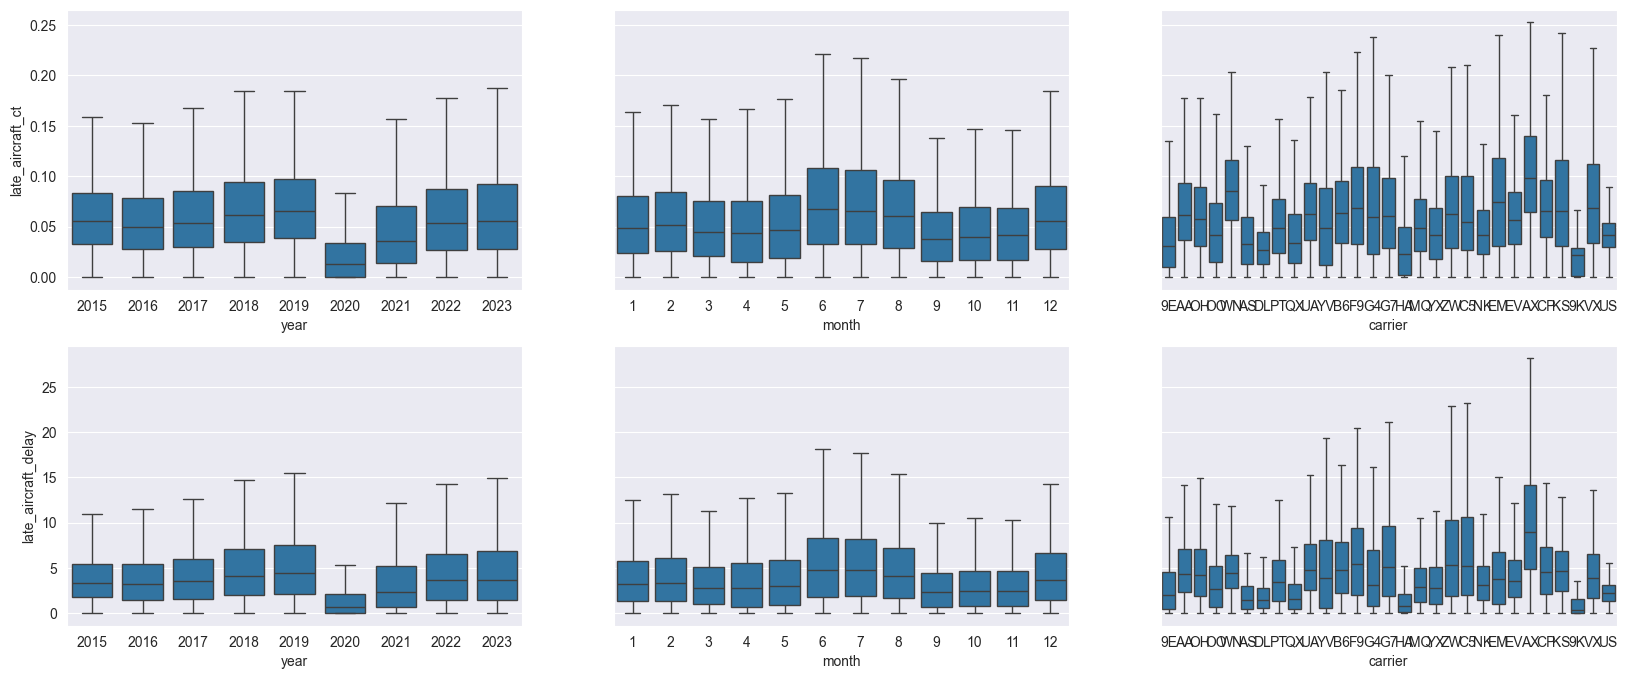

In [176]:
fig, axs = plt.subplots(2,3,figsize=(20,8),sharey='row')
sns.boxplot(data=dataNormalized, x='year',y='late_aircraft_ct',ax=axs[0,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='late_aircraft_ct',ax=axs[0,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='late_aircraft_ct',ax=axs[0,2],showfliers=False)

sns.boxplot(data=dataNormalized, x='year',y='late_aircraft_delay',ax=axs[1,0],showfliers=False)
sns.boxplot(data=dataNormalized, x='month',y='late_aircraft_delay',ax=axs[1,1],showfliers=False)
sns.boxplot(data=dataNormalized, x='carrier',y='late_aircraft_delay',ax=axs[1,2],showfliers=False)

<Axes: xlabel='airport', ylabel='arr_del15'>

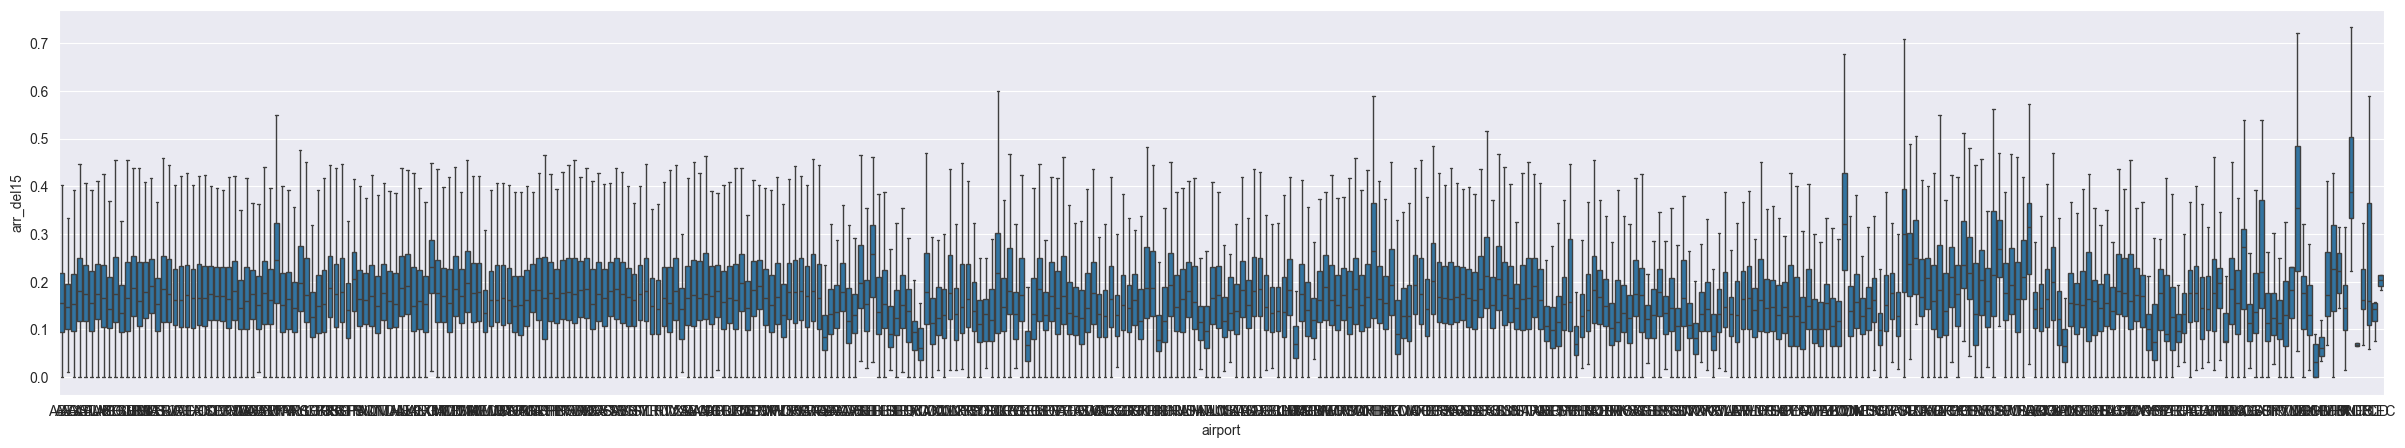

In [177]:
_,_ = plt.subplots(figsize=[30,5])
sns.boxplot(data=dataNormalized, x='airport',y='arr_del15',showfliers=False)


<Axes: xlabel='airport', ylabel='carrier_delay'>

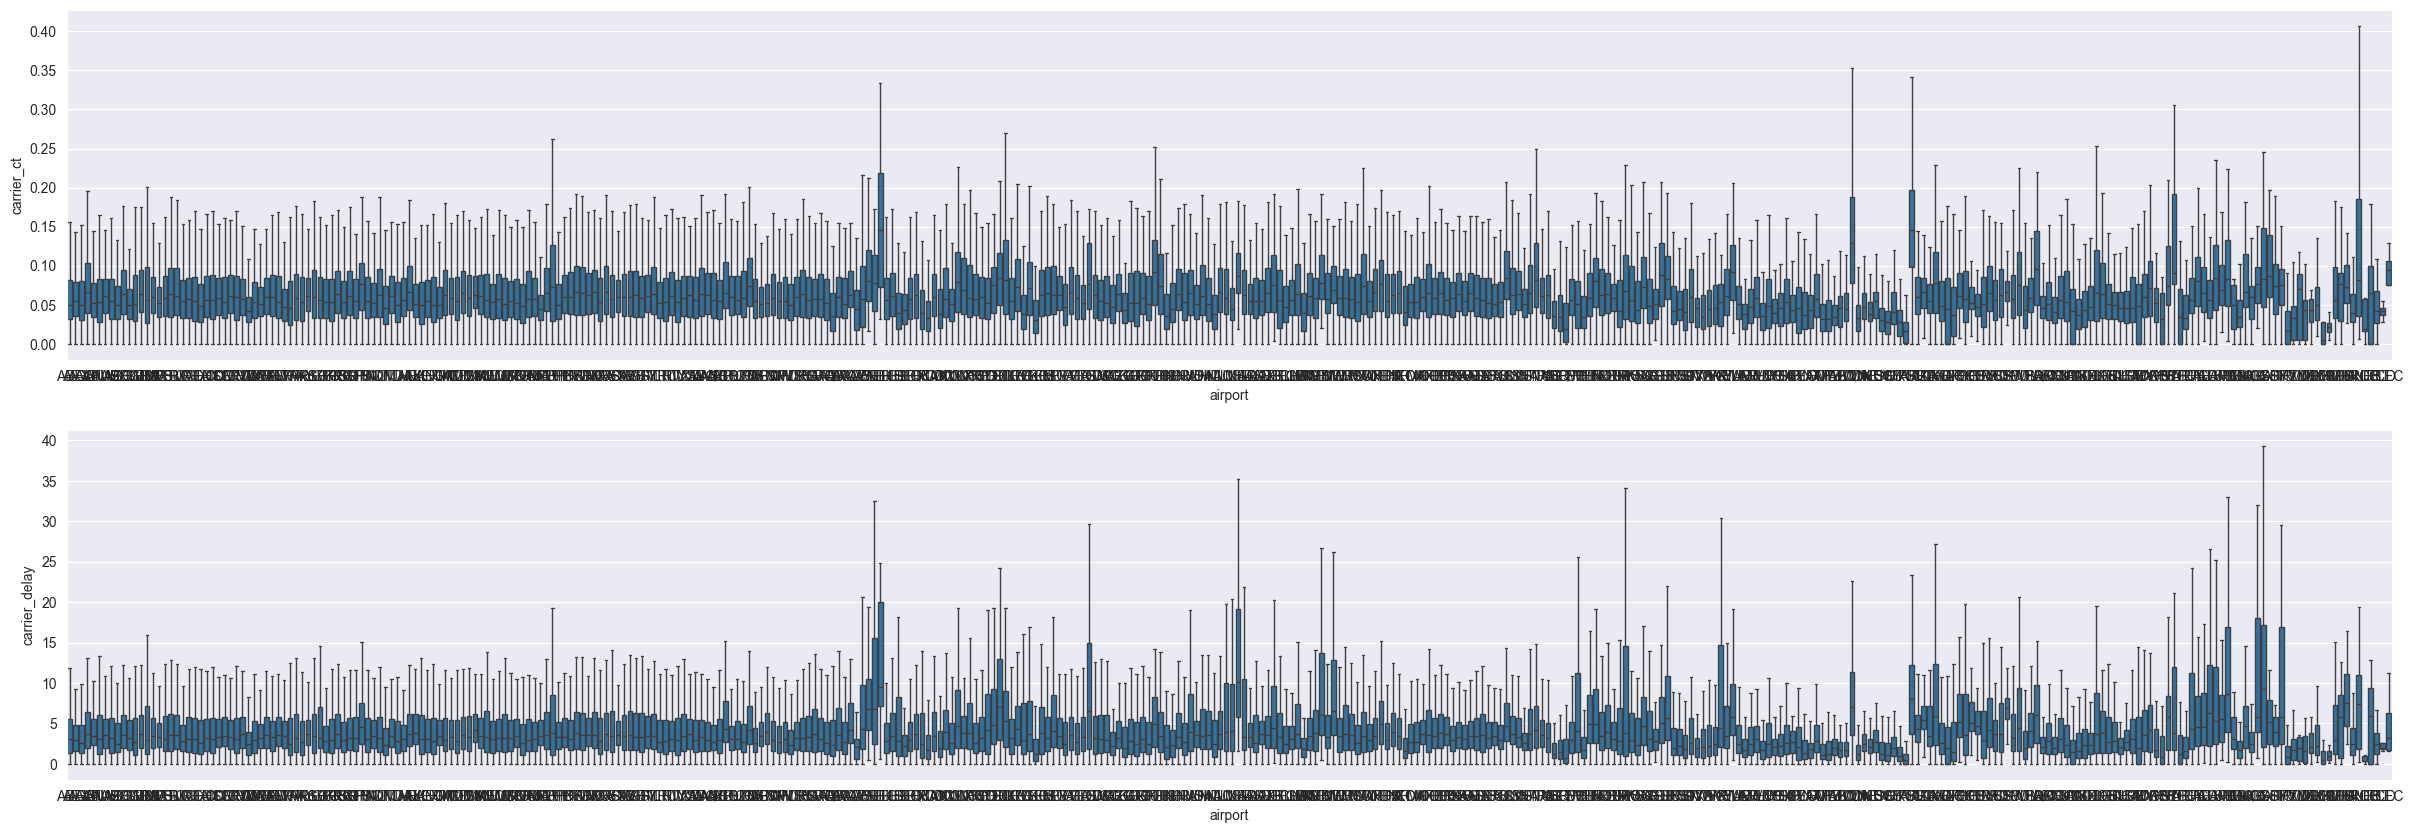

In [178]:
label = 'carrier'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataNormalized, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataNormalized, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='weather_delay'>

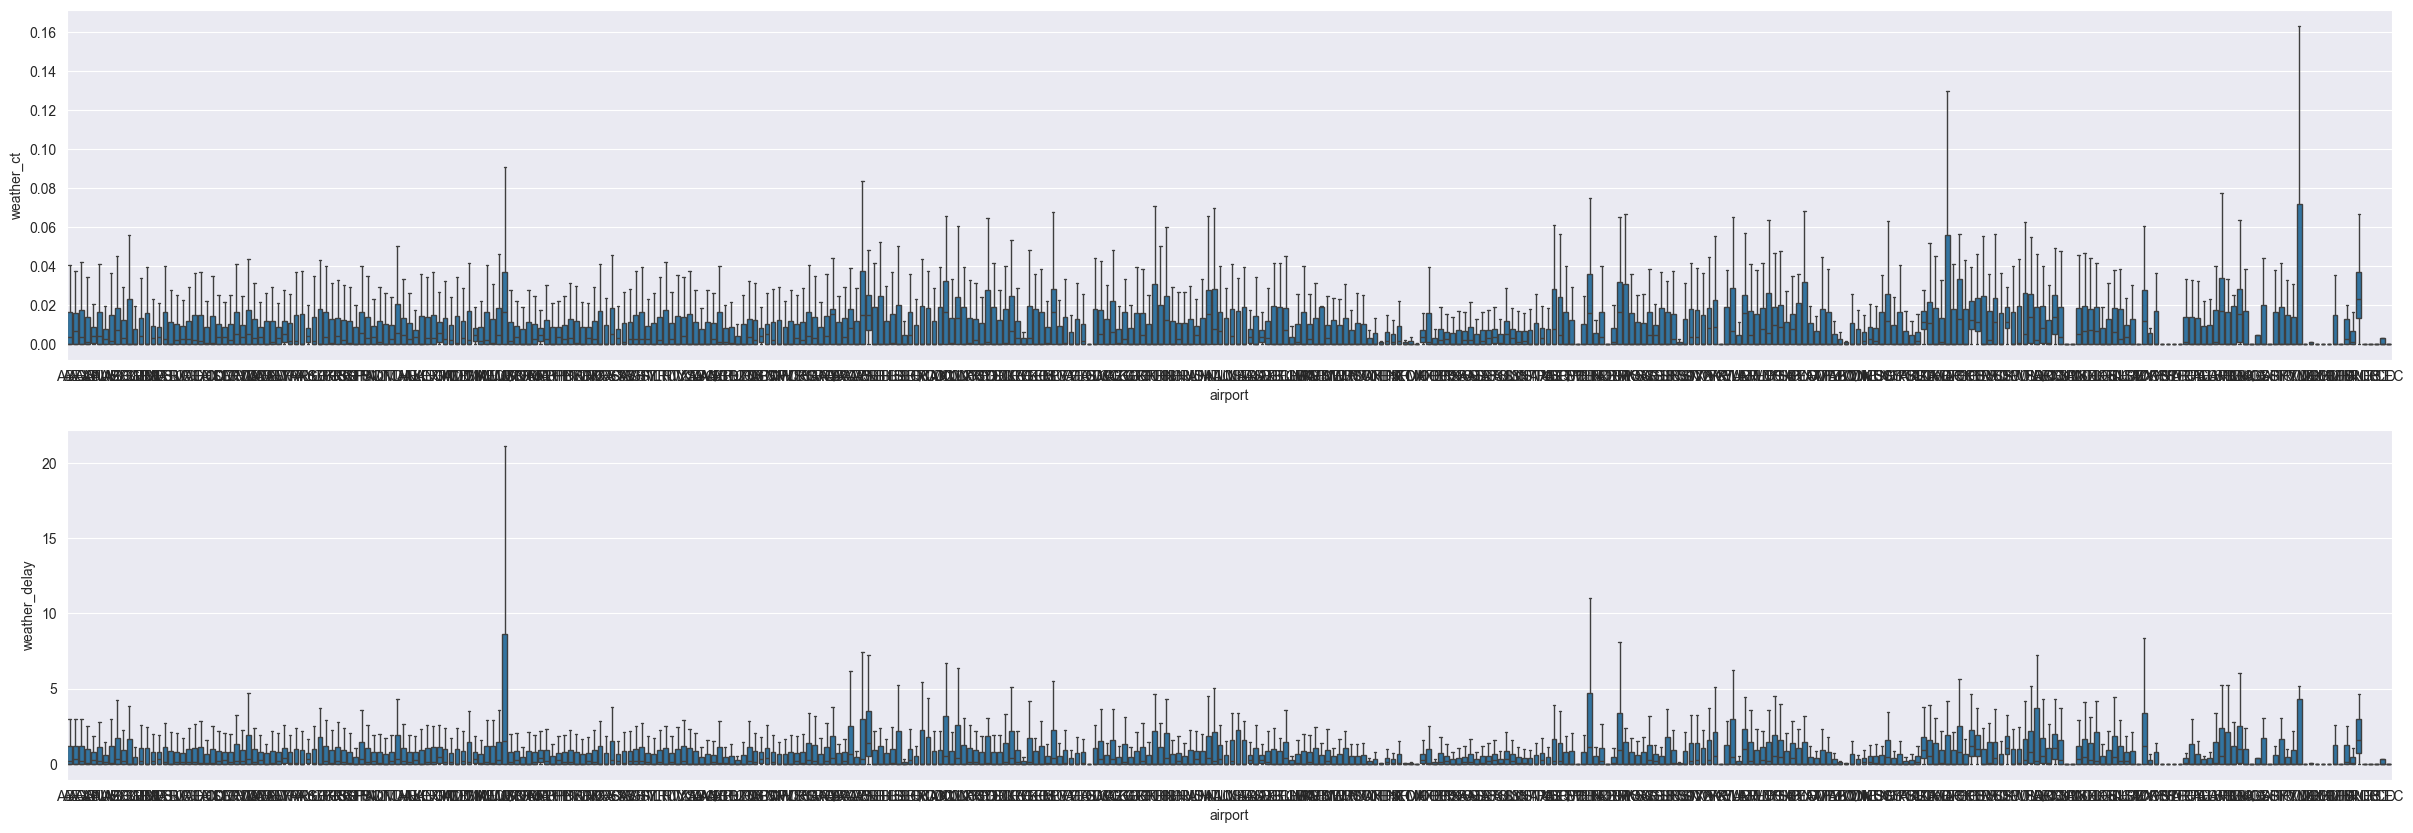

In [179]:
label = 'weather'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataNormalized, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataNormalized, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='nas_delay'>

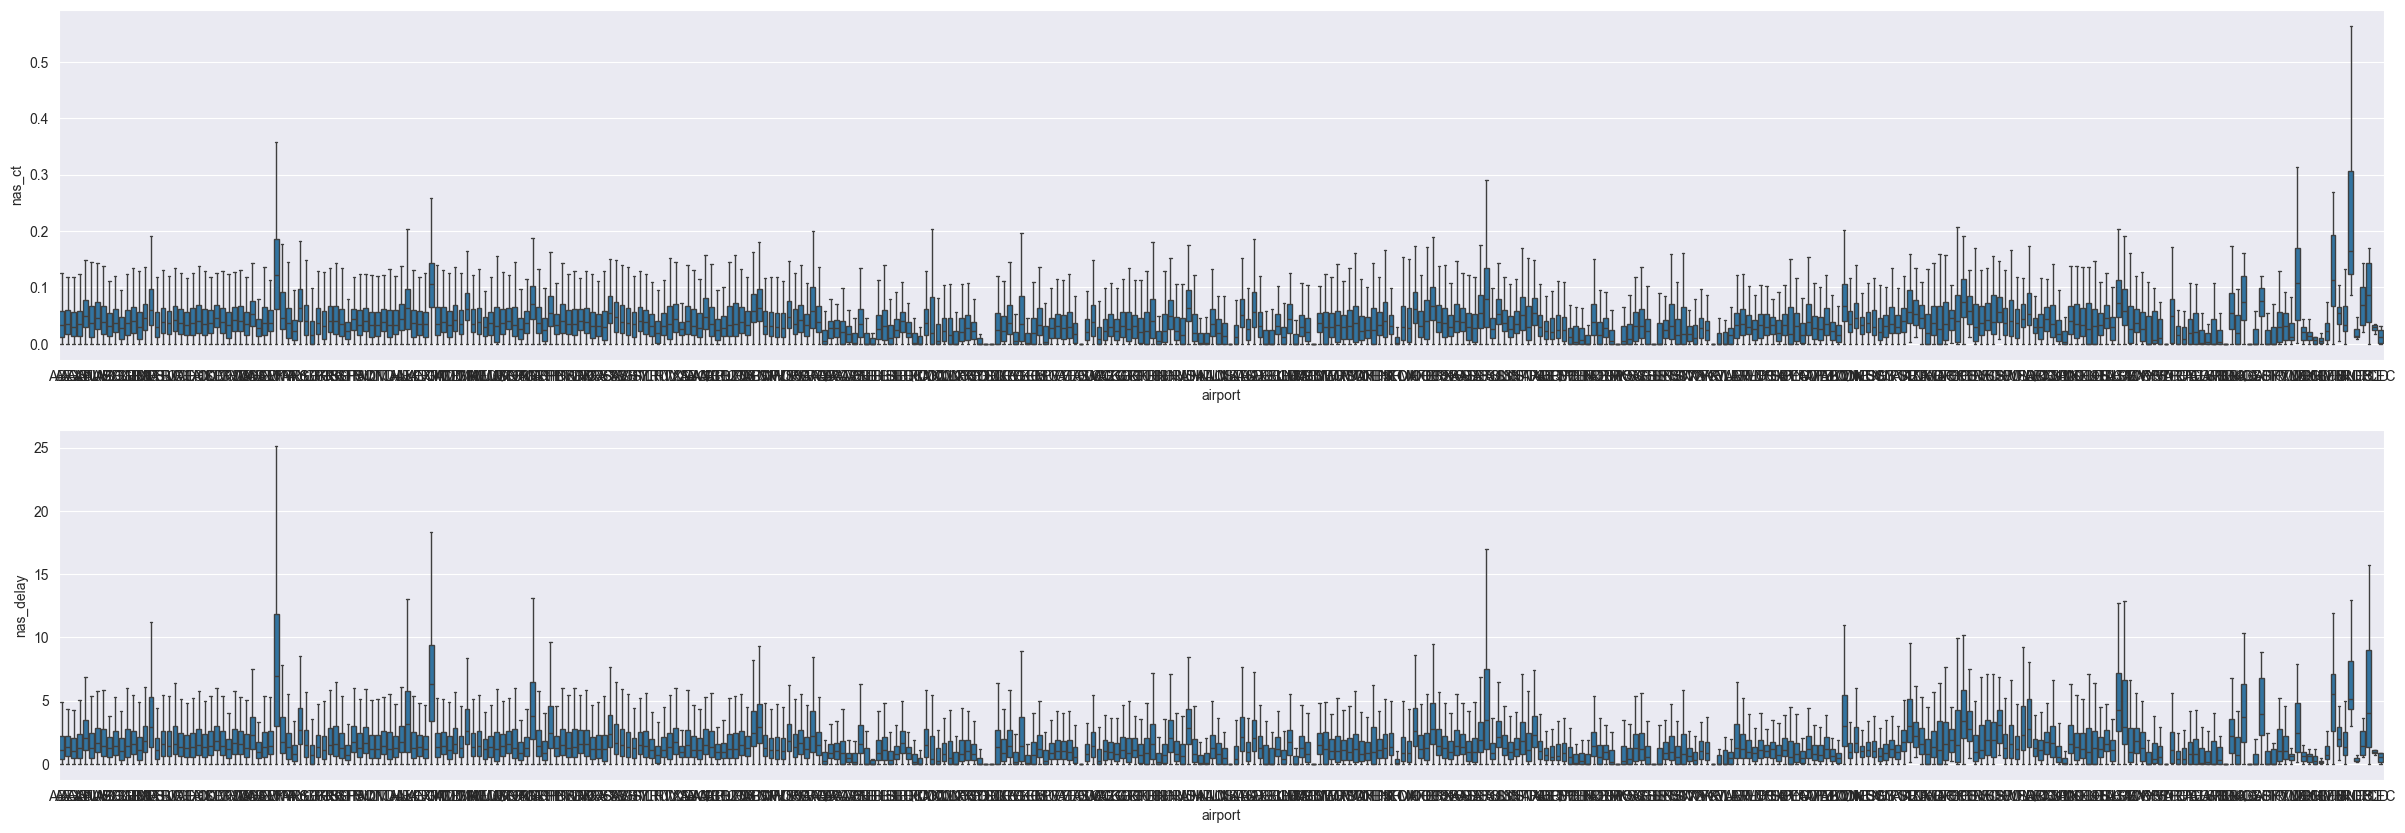

In [180]:
label = 'nas'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataNormalized, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataNormalized, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: xlabel='airport', ylabel='security_delay'>

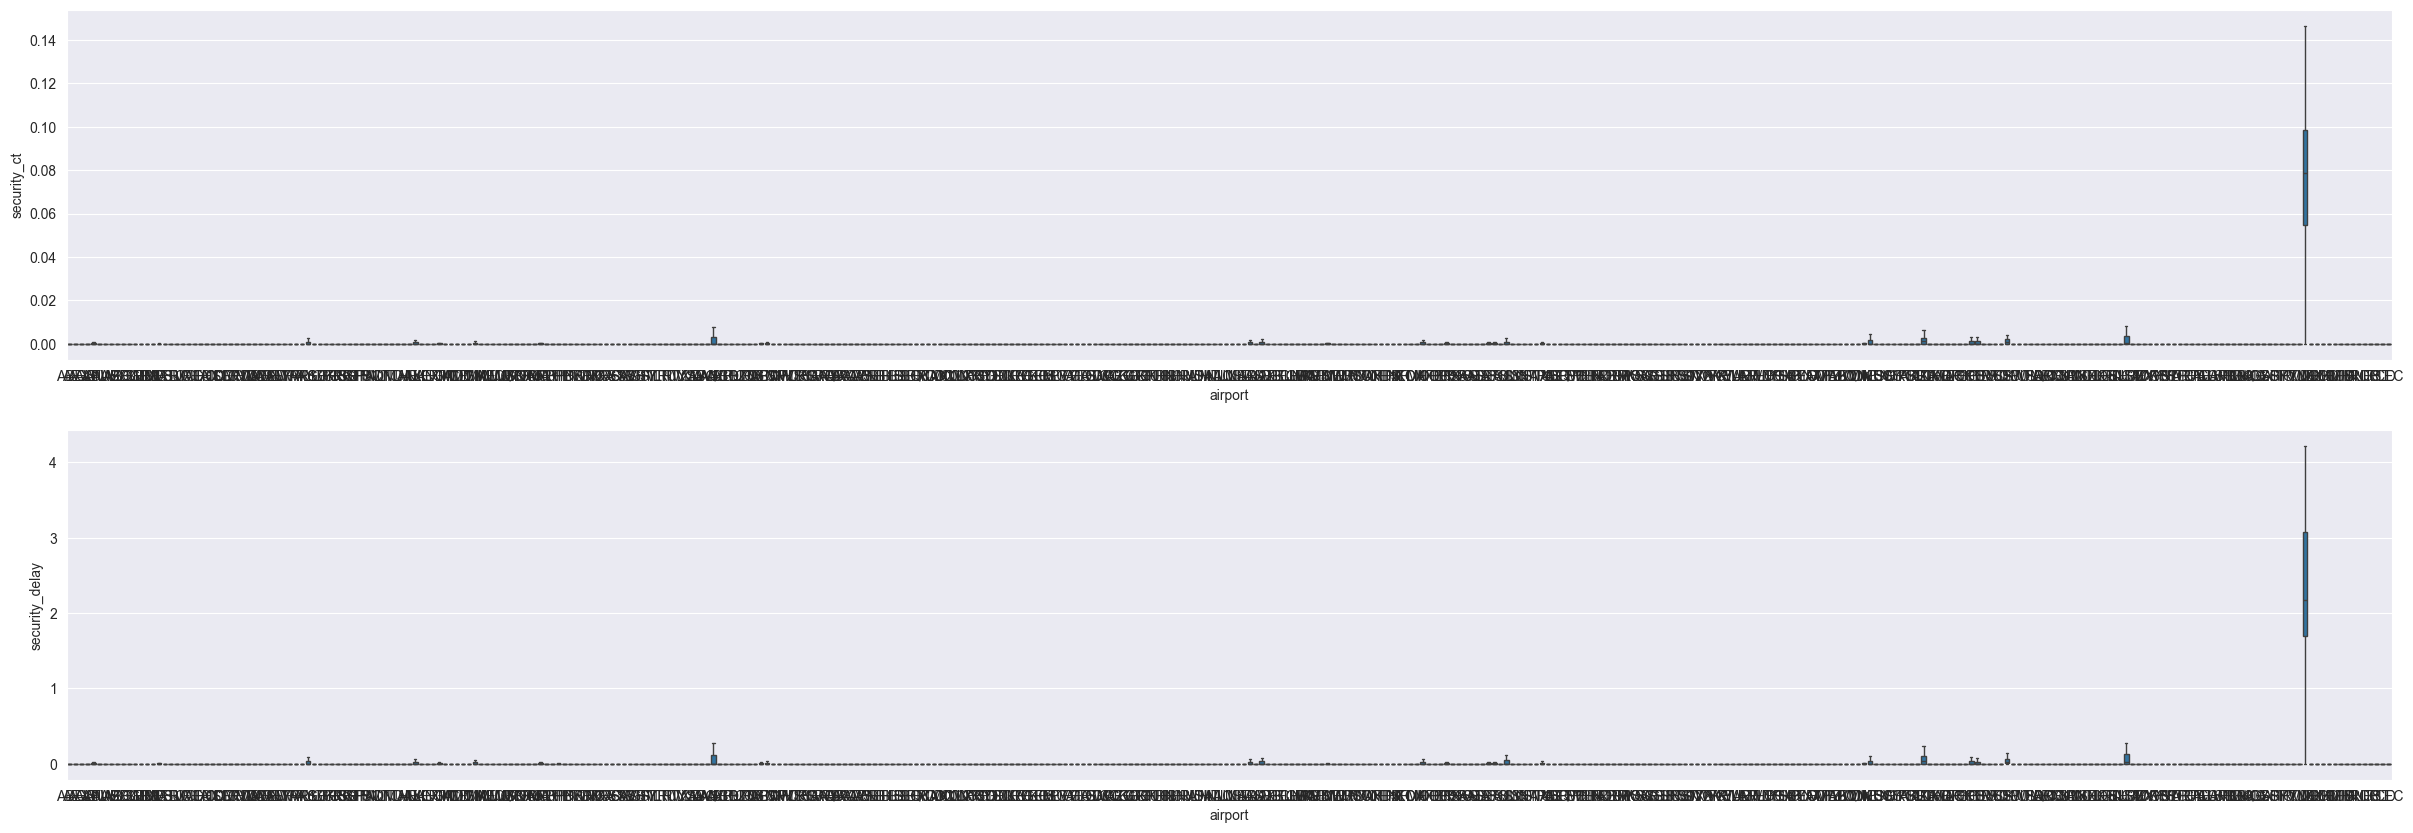

In [181]:
label = 'security'
_,axs = plt.subplots(2,1,figsize=[30,10])
sns.boxplot(data=dataNormalized, x='airport',y=label+'_ct', ax=axs[0], showfliers=False)
sns.boxplot(data=dataNormalized, x='airport',y=label+'_delay', ax=axs[1], showfliers=False)


<Axes: >

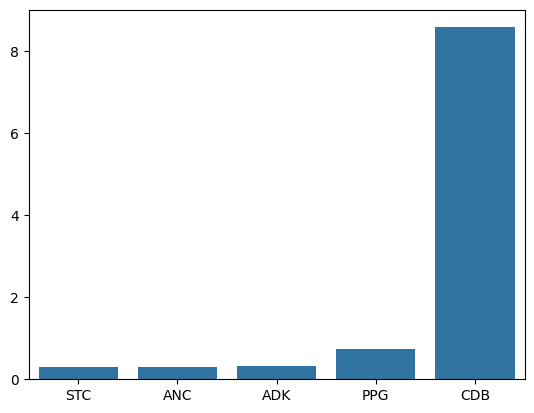

In [25]:
category = dataNormalized.airport.unique()
dic = {}
for cat in category:
    catRow = dataNormalized.security_ct[dataNormalized.airport == cat]
    dic[cat] = sum(catRow)/len(catRow)*100

sorted_dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
sns.barplot(x=list(sorted_dic.keys())[-5:], y = list(sorted_dic.values())[-5:])


In [144]:
# dataNormalized = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized['arr_flights'] > cutoff) if x],:]
security_ct_data = pd.DataFrame()
carriers_with_sec = ['AA','WN','B6','NK','US']

for car in carriers_with_sec:
    carrier_data = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized.carrier == car) if x],:]
    security_ct_data[car + '_carrier'] =  carrier_data.describe().security_ct

airport_data = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized.airport == 'CDB') if x],:]
security_ct_data['CDB_aiport'] = airport_data.describe().security_ct
security_ct_data
# dataNormalized.iloc[[i for i,x in enumerate(dataNormalized.airport == 'STC') if x],:]


,AA_carrier,WN_carrier,B6_carrier,NK_carrier,US_carrier,CDB_aiport
count,10663.000000,10048.000000,6718.000000,4860.000000,410.000000,14.000000
mean,0.000558,0.000488,0.001115,0.002067,0.001208,0.076662
std,0.001643,0.001208,0.003630,0.005372,0.002563,0.042240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.054740
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.078611
75%,0.000358,0.000496,0.000295,0.001941,0.001334,0.098385
max,0.029333,0.032667,0.058750,0.076923,0.018636,0.146667


# Training 

In [ ]:
from sklearn.preprocessing  import StandardScaler

data_encoded = pd.get_dummies(dataNormalized,columns=['carrier','airport'],drop_first=True)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)
data_scaled = pd.DataFrame(data_scaled,columns=data_encoded.columns)

data_scaled

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,carrier_9K,carrier_AA,carrier_AS,carrier_AX,carrier_B6,carrier_C5,carrier_CP,carrier_DL,carrier_EM,carrier_EV,carrier_F9,carrier_G4,carrier_G7,carrier_HA,carrier_KS,carrier_MQ,carrier_NK,carrier_OH,carrier_OO,carrier_PT,carrier_QX,carrier_UA,carrier_US,carrier_VX,carrier_WN,carrier_YV,carrier_YX,carrier_ZW,airport_ABI,airport_ABQ,airport_ABR,airport_ABY,airport_ACK,airport_ACT,airport_ACV,airport_ACY,airport_ADK,airport_ADQ,airport_AEX,airport_AGS,airport_AKN,airport_ALB,airport_ALO,airport_ALS,airport_ALW,airport_AMA,airport_ANC,airport_APN,airport_ART,airport_ASE,airport_ATL,airport_ATW,airport_ATY,airport_AUS,airport_AVL,airport_AVP,airport_AZA,airport_AZO,airport_BDL,airport_BET,airport_BFF,airport_BFL,airport_BFM,airport_BGM,airport_BGR,airport_BHM,airport_BIH,airport_BIL,airport_BIS,airport_BJI,airport_BKG,airport_BLI,airport_BLV,airport_BMI,airport_BNA,airport_BOI,airport_BOS,airport_BPT,airport_BQK,airport_BQN,airport_BRD,airport_BRO,airport_BRW,airport_BTM,airport_BTR,airport_BTV,airport_BUF,airport_BUR,airport_BWI,airport_BZN,airport_CAE,airport_CAK,airport_CDB,airport_CDC,airport_CDV,airport_CEC,airport_CGI,airport_CHA,airport_CHO,airport_CHS,airport_CID,airport_CIU,airport_CKB,airport_CLD,airport_CLE,airport_CLL,airport_CLT,airport_CMH,airport_CMI,airport_CMX,airport_CNY,airport_COD,airport_COS,airport_COU,airport_CPR,airport_CRP,airport_CRW,airport_CSG,airport_CVG,airport_CWA,airport_CYS,airport_DAB,airport_DAL,airport_DAY,airport_DBQ,airport_DCA,airport_DDC,airport_DEC,airport_DEN,airport_DFW,airport_DHN,airport_DIK,airport_DLG,airport_DLH,airport_DRO,airport_DRT,airport_DSM,airport_DTW,airport_DUT,airport_DVL,airport_EAR,airport_EAT,airport_EAU,airport_ECP,airport_EFD,airport_EGE,airport_EKO,airport_ELM,airport_ELP,airport_ENV,airport_ERI,airport_ESC,airport_EUG,airport_EVV,airport_EWN,airport_EWR,airport_EYW,airport_FAI,airport_FAR,airport_FAT,airport_FAY,airport_FCA,airport_FLG,airport_FLL,airport_FLO,airport_FNL,airport_FNT,airport_FOD,airport_FSD,airport_FSM,airport_FWA,airport_GCC,airport_GCK,airport_GEG,airport_GFK,airport_GGG,airport_GJT,airport_GNV,airport_GPT,airport_GRB,airport_GRI,airport_GRK,airport_GRR,airport_GSO,airport_GSP,airport_GST,airport_GTF,airport_GTR,airport_GUC,airport_GUM,airport_HDN,airport_HGR,airport_HHH,airport_HIB,airport_HLN,airport_HNL,airport_HOB,airport_HOU,airport_HPN,airport_HRL,airport_HSV,airport_HTS,airport_HVN,airport_HYA,airport_HYS,airport_IAD,airport_IAG,airport_IAH,airport_ICT,airport_IDA,airport_IFP,airport_ILG,airport_ILM,airport_IMT,airport_IND,airport_INL,airport_IPT,airport_ISN,airport_ISP,airport_ITH,airport_ITO,airport_JAC,airport_JAN,airport_JAX,airport_JFK,airport_JHM,airport_JLN,airport_JMS,airport_JNU,airport_JST,airport_KOA,airport_KTN,airport_LAN,airport_LAR,airport_LAS,airport_LAW,airport_LAX,airport_LBB,airport_LBE,airport_LBF,airport_LBL,airport_LCH,airport_LCK,airport_LEX,airport_LFT,airport_LGA,airport_LGB,airport_LIH,airport_LIT,airport_LNK,airport_LNY,airport_LRD,airport_LSE,airport_LWB,airport_LWS,airport_LYH,airport_MAF,airport_MBS,airport_MCI,airport_MCO,airport_MCW,airport_MDT,airport_MDW,airport_MEI,airport_MEM,airport_MFE,airport_MFR,airport_MGM,airport_MHK,airport_MHT,airport_MIA,airport_MKE,airport_MKG,airport_MKK,airport_MLB,airport_MLI,airport_MLU,airport_MMH,airport_MOB,airport_MOT,airport_MQT,airport_MRY,airport_MSN,airport_MSO,airport_MSP,airport_MSY,airport_MTJ,airport_MVY,airport_MYR,airport_OAJ,airport_OAK,airport_OGD,airport_OGG,airport_OGS,airport_OKC,airport_OMA,airport_OME,airport_ONT,airport_ORD,airport_ORF,airport_ORH,airport_OTH,airport_OTZ,airport_OWB,airport_PAE,airport_PAH,airport_PBG,airport_PBI,airport_PDX,airport_PGD,airport_PGV,airport_PHF,airport_PHL,airport_PHX,airport_PIA,airport_PIB,airport_PIE,airport_PIH,airport_PIR,airport_PIT,airport_PLN,a

In [87]:
label_df = data_scaled.loc[:,'arr_del15':'late_aircraft_delay']
feature_df = pd.concat([data_scaled.loc[:,:'month'],data_scaled.loc[:,'carrier_9K':]],axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=10)

def cross_validation(reg_model, housing_prepared, housing_labels):
    scores = cross_val_score(
      reg_model, housing_prepared,
      housing_labels,
      scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print("Scores:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("StandardDeviation:", rmse_scores.std())


print("----- Linear Regression Model Cross Validation ------")
lin_reg = LinearRegression()
cross_validation(lin_reg, feature_df, label_df)
print("")
print("----- lasso Regression Model Cross Validation ------")
lasso_reg = Lasso()
cross_validation(lasso_reg, feature_df, label_df)
print("")
# print("----- Decision Tree Regression Model Cross Validation ------")
# tree_reg = DecisionTreeRegressor()
# cross_validation(tree_reg, feature_df, label_df)
# print("")
# print("----- Random Forest Regression Model Cross Validation ------")
# forest_reg = RandomForestRegressor()
# cross_validation(forest_reg, feature_df, label_df)
# print("")
# print("----- xgboost Regression Model Cross Validation ------")
# xgb_reg = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# cross_validation(xgb_reg, feature_df, label_df)

----- Linear Regression Model Cross Validation ------
Scores: [1.03046736 1.08861239 0.92835535 1.13517545 0.91104787 0.98420947
 0.89822229 0.87662096 0.80033316 0.78085702]
Mean: 0.9433901324293853
StandardDeviation: 0.11035053439786585

----- lasso Regression Model Cross Validation ------
Scores: [1.09662471 1.15685216 0.99649725 1.1889791  0.90859282 1.0454386
 0.95982032 0.93210323 0.87019673 0.81594212]
Mean: 0.9971047045815077
StandardDeviation: 0.11702606035384286

